# Detect and track players, ball and referee in football match using `YOLO v11`, `roboflow` and `supervision` packages.

- Using `roboflow` to create dataset
- Using `YOLO` to train model and detect players and ball
- Using `supervision` to visualize boxes around detected objects and set label for them
---

### Install pytorch compatible with `CUDA`
#### First of all download and install `CUDA toolkit` compatible with your Nvidia graphics card from [this link](https://developer.nvidia.com/cuda-downloads)

#### Then install `pytorch` from [this way](https://pytorch.org/get-started/locally/):

![installing pytorch compatible to CUDA platform](https://storage4.fastupload.io/cache/plugins/filepreviewer/1052705/8017b8ce4f4a0e776cea0e8a587c715f726898722aa25e17f183bb5bd0173e56/1100x800_cropped.jpg)

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

---
### Verify Nvidia is access

In [1]:
!nvidia-smi

Fri Nov 29 23:08:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              4W /   73W |    1323MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

-----
### install required packages

In [ ]:
!pip install -q ultralytics roboflow supervision

---
### Download ball, players and referee detection dataset from [this link](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

![installing pytorch compatible to CUDA platform](https://storage4.fastupload.io/cache/plugins/filepreviewer/1052707/653f60f51208aca0f168a58b3ec75bcef3dd428b26861d9dc37b3e69f7566bca/1100x800_cropped.jpg)

---
### Download base model of `YOLO` form [this link](https://docs.ultralytics.com/tasks/detect/#models)
![models image](https://storage6.fastupload.io/cache/plugins/filepreviewer/1052706/9695a0099b9f2d20a6aec3a756c7bcd120848585c9bf90eb33e72a69599ef4ed/1100x800_cropped.jpg)
#### I used `YOLO11s`

---
### Imports

In [ ]:
import os
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm
from sports.common.team import TeamClassifier
import supervision as sv

---
### Predefined Variables

In [3]:
HOME = os.getcwd()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---
### Train model to detect `players`, `ball` and `referee`

In [ ]:
base_model = YOLO(f'{HOME}/datasets/yolo11s.pt')
base_model.train(data=f"{HOME}/football/data.yaml", epochs=50, batch=8, imgsz=1280, plots=True, device=DEVICE)

--------
### Validate trained model

In [ ]:
base_model.val(data=f'{HOME}/football/data.yaml', imgsz=1280, device=DEVICE)

#### Our Model Trained Path

In [13]:
OUR_MODEL_PATH = f'{HOME}/runs/detect/train4/weights/best.pt'
SOURCE_VIDEO_PATH = f"{HOME}\clips\download.mp4"

---
### Download football match clips

- https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
- https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
- https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
- https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
- https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu

---
### Object IDs

In [5]:
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

---
### Detect `players`, `ball` and `referee` just using `YOLO`

In [ ]:
model = YOLO(OUR_MODEL_PATH)
result = model(source=SOURCE_VIDEO_PATH, show=True, conf=0.4, save=True)

---
### Collect Crops Of Players

In [ ]:
STRIDE = 30


def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)
    yolo_model = YOLO(OUR_MODEL_PATH)

    crops = []
    for frame in tqdm(frame_generator, desc="Extracting crops..."):
        results = yolo_model(frame, conf=0.3, save=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = detections[detections.class_id == PLAYER_ID]
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ]
    return crops


In [ ]:
crops = extract_crops(SOURCE_VIDEO_PATH)

In [ ]:
len(crops)

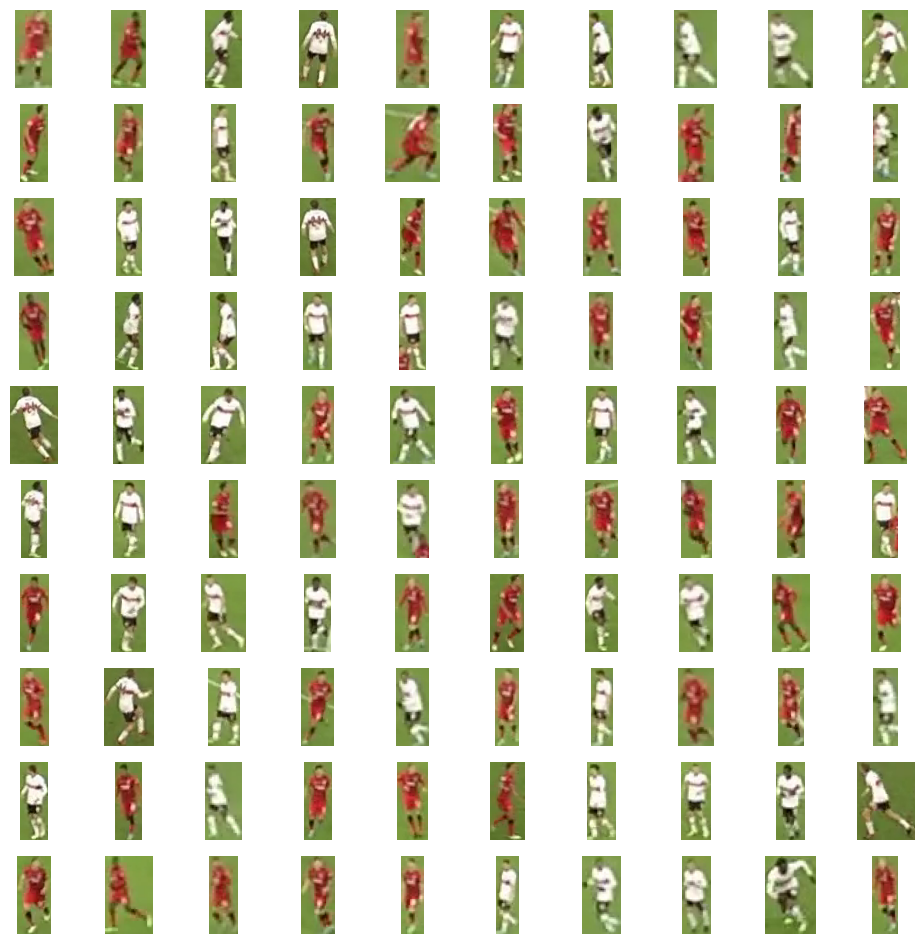

In [17]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

---
### Team Classification

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

In [18]:
def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections):
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Extracting crops...: 0it [00:00, ?it/s]


0: 736x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 13.6ms
Speed: 6.6ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 1it [00:00,  1.26it/s]


0: 736x1280 1 goalkeeper, 22 players, 1 referee, 11.5ms
Speed: 5.5ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 6.4ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 10.0ms
Speed: 6.5ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 4it [00:00,  5.38it/s]


0: 736x1280 1 ball, 21 players, 2 referees, 11.6ms
Speed: 5.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 10.8ms
Speed: 7.0ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.8ms
Speed: 8.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 7it [00:01,  9.12it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 7.7ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.4ms
Speed: 7.2ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 10it [00:01, 12.37it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 12.2ms
Speed: 7.4ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 7.5ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 11.1ms
Speed: 6.0ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 13it [00:01, 15.08it/s]


0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.3ms
Speed: 5.8ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 10.2ms
Speed: 5.8ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 16it [00:01, 17.33it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.5ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 13.0ms
Speed: 7.3ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 10.2ms
Speed: 6.5ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 19it [00:01, 18.72it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.9ms
Speed: 7.5ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.6ms
Speed: 7.2ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.5ms
Speed: 7.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 22it [00:01, 20.00it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.6ms
Speed: 6.8ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.4ms
Speed: 5.7ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 7.7ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 25it [00:01, 13.47it/s]
Embedding extraction: 16it [00:04,  3.90it/s]



0: 736x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 69.3ms
Speed: 4.8ms preprocess, 69.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.63it/s]


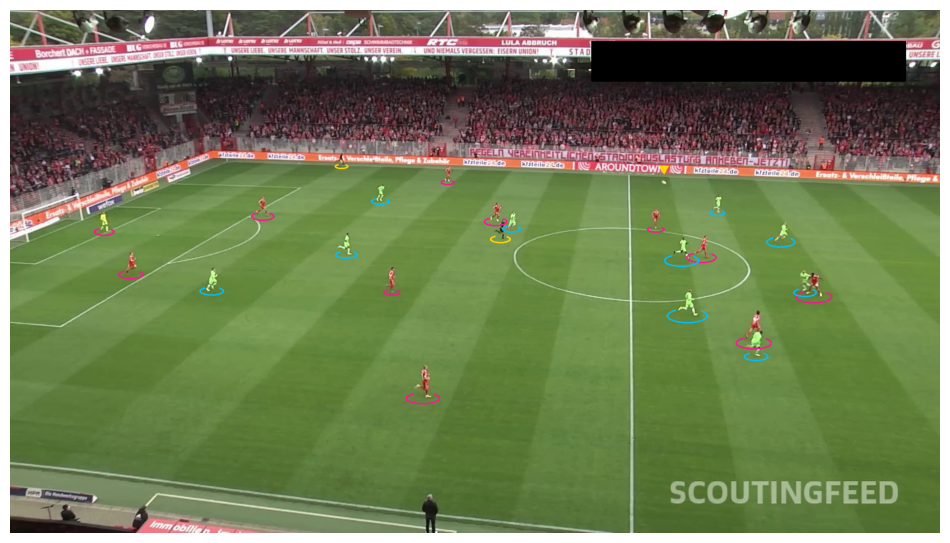

In [11]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = yolo_model(frame, conf=0.4, save=False)[0]

detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
sv.plot_image(annotated_frame)


In [ ]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False, device=DEVICE)[0]

        detections = sv.Detections.from_ultralytics(results)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        video_sink.write_frame(annotated_frame)


<div style="padding:56.25% 0 0 0;position:relative;"><iframe src="https://player.vimeo.com/video/1034625565?h=4b876b7c2b&amp;badge=0&amp;autopause=0&amp;player_id=0&amp;app_id=58479" frameborder="0" allow="autoplay; fullscreen; picture-in-picture; clipboard-write" style="position:absolute;top:0;left:0;width:100%;height:100%;" title="Football players, ball and referee detection"></iframe></div><script src="https://player.vimeo.com/api/player.js"></script>